# Exploratory Analysis 

1. **Driver Attributes vs. Accident Risk**  
   - Question: Are certain driver attributes (age, rating, experience) correlated with higher accident frequency or cost?  
   - Data: `driver_data_df`, filtered `service_type_df` for `claim_type == 'Accident'` (merged on `driver_id`), `vehicle_driver_df`

2. **Exposure-Adjusted Accident Rates**  
   - Question: Which drivers have the highest accident rate *per mile driven* or *per trip*?  
   - Data: `trip_logs_df` (miles and trip counts per driver), `service_type_df` for accidents

3. **Vehicle Age & Claim Patterns**  
   - Question: How does vehicle age impact accident frequency, accident cost, and downtime?  
   - Data: `vehicle_data_df` (vehicle_age), `service_type_df`, `vehicle_driver_df`

4. **Fuel Type & Operating Risk**  
   - Question: Do petrol, diesel, hybrid, or electric vehicles differ in accident rate or cost when adjusted for usage?  
   - Data: `vehicle_data_df` (type), merged accident and trip data

5. **Time-Series Drivers of Cost**

- Question: Are there seasonal or monthly patterns in accident frequency or maintenance cost across the fleet?
- Data: Use service_type_df grouped by month, showing trends in accident counts, maintenance cost, and normalized metrics like cost per mile.

   5.1 **Time-Series Drivers of Profitability**

       - Question: How do these monthly cost drivers relate to profitability (e.g., profit after tax)?

      - Data: Merge cost/time-series data with financials (profit_vehicles_df), then analyze or visualize how cost per mile trends correspond to fluctuations in profit.

6. **Downtime Drivers**  
   - Question: What factors (claims type, vehicle type, driver) drive longer downtime per incident?  
   - Data: `merge_service_vehicle_driver` (`downtime_hours`), plus vehicle and driver attributes

7. **Cost vs. Revenue Trade‑offs**  
   - Question: How does high-risk (costly) vehicle or driver segments correlate with profitability?  
   - Data: Combined `profit_vehicles_df`, accident cost data, trip revenue

8. **Predictors of High-Cost Incidents**  
   - Question: Can we build a simple model to predict which incidents (or drivers) will exceed a cost threshold?  
   - Data: All incident-level attributes from `service_type_df`, driver and vehicle features

9. **Impact of Contract Terms**  
   - Question: Do drivers on different contract lengths or rent tiers show different accident or revenue patterns?  
   - Data: `vehicle_driver_df` (contract_start/end), rental rate data (if available)

10. **Cost‑Saving Scenario Analysis**  
    - Question: What % cost savings could the business realize by, for example, rotating out vehicles older than X years or retraining drivers in the top risk quartile?  
    - Data: Use your descriptive cost and usage summaries to model “what if” scenarios; this may be best done in a separate **Scenario Analysis** or **Forecasting** file.

In [157]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime
financial_data_df=pd.read_csv("../data/corporate_profit_and_loss_summary.csv")
driver_data_df=pd.read_csv('../data/drivers_data.csv')
vehicle_driver_assignment_df = pd.read_csv("../data/vehicle_driver_assignment.csv")
profit_vehicles_df = pd.read_csv("../data/profit_per_vehicle.csv")
vehicle_data_df = pd.read_csv("../data/vehicles_data.csv")
maintenance_cost = pd.read_csv("../data/material_usage_per_vehicle.csv")

service_type_df= pd.read_csv("../data/service_type.csv") 

vehicle_profit_df= pd.read_csv('../data/profit_per_vehicle.csv')

trip_logs_df = pd.read_csv("../data/trip_logs.csv")

In [158]:
accidents_df = service_type_df[service_type_df['claim_type'] == 'Accident']

merged = pd.merge(accidents_df, vehicle_driver_assignment_df, on='vehicle_id', how='left')

merged.columns
## filter rows ehere the event_data fails withing the drivers contract period 
filtered = merged[(merged['event_date'] >= merged['contract_start']) & (merged['event_date'] <= merged['contract_end'])]


filtered.columns
filtered['driver_id']= filtered['driver_id_y']
filtered = filtered.drop(columns=['driver_id_x','driver_id_y'])
## merge with driver details 
result = pd.merge(filtered, driver_data_df, on='driver_id', how='left')


accident_costs_per_driver = (
    result.groupby(['driver_id','name','age'])['cost']
    .sum()
    .reset_index()
    .sort_values(by='cost', ascending=False)
)
accident_costs_per_driver.head(5)


C:\Users\yeahm\AppData\Local\Temp\ipykernel_26628\3470483272.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['driver_id']= filtered['driver_id_y']


,driver_id,name,age,cost
14,D0018,Bakhshi Mody,37,5911
28,D0033,Gregory Oliver,46,4942
21,D0025,Anthony Rich,32,4550
40,D0045,Anthony Deep,39,4066
42,D0048,Faraj Bedi,26,3984


In [159]:

result.columns

group_by_accident_events=(
    result
    .groupby(['driver_id','vehicle_id','name','age'])['event_id']
    .count()
    .reset_index(name='event_count')
    .sort_values(by='event_count',ascending=False)
)


group_by_accident_events.head(20)

,driver_id,vehicle_id,name,age,event_count
14,D0018,V0018,Bakhshi Mody,37,7
40,D0045,V0045,Anthony Deep,39,5
42,D0048,V0048,Faraj Bedi,26,5
37,D0042,V0042,Vincent Pandit,35,5
7,D0010,V0010,Jonathon Roberts,26,4
39,D0044,V0044,Jerry Moore,42,4
36,D0041,V0041,Tejas Memon,48,4
21,D0025,V0025,Anthony Rich,32,4
31,D0036,V0036,Max Varughese,28,4
8,D0011,V0011,Nicholas Ryan,40,3


In [160]:

result.columns

merge_driver_trip_log= pd.merge(trip_logs_df,driver_data_df, on='driver_id' ,how='inner')

merge_driver_trip_log.columns

## First aggregate trip count based on driver_id 
group_by_trip_count=(
    merge_driver_trip_log
    .groupby(['driver_id'])['trip_id']
    .count()
    .reset_index(name='trip_count')
    .sort_values(by='trip_count',ascending=False)
)

## next aggregate by total milage 
group_by_total_mileage=(
    merge_driver_trip_log
    .groupby(['driver_id'])['distance_miles']
    .sum()
    .reset_index(name='total_mileage')
    .sort_values(by='total_mileage',ascending=False)
)

group_by_trip_count.head()
group_by_total_mileage.head()

result = result.merge(group_by_trip_count, on='driver_id', how='left')
result = result.merge(group_by_total_mileage, on='driver_id', how='left')

## 1. Are certain driver attributes (e.g., age, rating, experience) correlated with higher accident frequency or cost?
* Relevant tables:drivers_data, service_type (claim_type == 'Accident' with driver_id),vehicle_driver_assignments

In [161]:
result.columns

result['contract_end'] = pd.to_datetime(result['contract_end'],errors='coerce')
result['contract_start'] = pd.to_datetime(result['contract_start'],errors='coerce')
result['contract_days']= (result['contract_end']-result['contract_start']).dt.days


#compute experience
result['experience']=(
    result['contract_days'].fillna(0)*0.5+
    result['trip_count'].fillna(0)*1+
    result['total_mileage'].fillna(0)*0.01
)



In [102]:
## accident frequency per driver 
# Accident frequency per driver
accident_freq = result.groupby('driver_id').size().reset_index(name='accident_frequency')

## Accident  cost per driver 
accident_cost = result.groupby('driver_id')['cost'].sum().reset_index(name='accident_cost')

accident_freq.head()
accident_cost.head()

,driver_id,accident_cost
0,D0001,2741
1,D0003,592
2,D0004,1175
3,D0005,1913
4,D0007,561


In [162]:
print(result[['driver_id']].head())
print(result['driver_id'].nunique())
print(accident_freq.head())



  driver_id
0     D0001
1     D0001
2     D0001
3     D0003
4     D0004
45
  driver_id  accident_frequency
0     D0001                   3
1     D0003                   1
2     D0004                   1
3     D0005                   2
4     D0007                   1


object
object
count    90.000000
mean      3.111111
std       1.645180
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       7.000000
Name: accident_frequency, dtype: float64
6


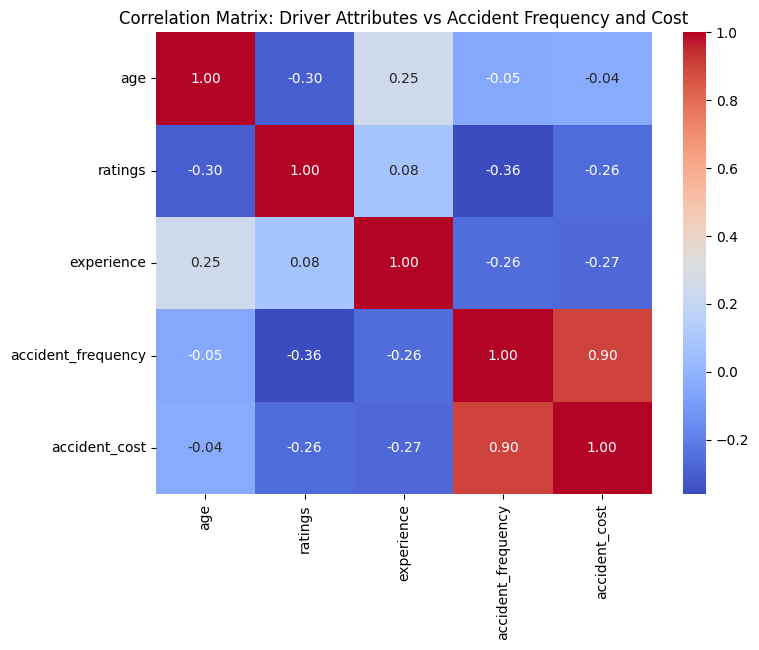

,age,ratings,experience,accident_frequency,accident_cost
age,1.000000,-0.304475,0.249625,-0.051739,-0.036855
ratings,-0.304475,1.000000,0.075652,-0.360800,-0.260166
experience,0.249625,0.075652,1.000000,-0.257205,-0.270633
accident_frequency,-0.051739,-0.360800,-0.257205,1.000000,0.899409
accident_cost,-0.036855,-0.260166,-0.270633,0.899409,1.000000


In [163]:
## Merge them 

## select driver attributes 1 row per driver 
drivers = result[['driver_id','age','ratings','experience']].drop_duplicates()

print(drivers['driver_id'].dtype)
print(accident_freq['driver_id'].dtype)
## merge accident frequency and cost 

driver_accident_stats = drivers.merge(accident_freq,on='driver_id',how='left').merge(accident_cost,on='driver_id',how='left')


# Fill NaN (drivers with zero accidents)
driver_accident_stats['accident_frequency'] = driver_accident_stats['accident_frequency'].fillna(0)
driver_accident_stats['accident_cost'] = driver_accident_stats['accident_cost'].fillna(0)

print(driver_accident_stats['accident_frequency'].describe())
print(driver_accident_stats['accident_frequency'].nunique())
## Calculate correlations 

correlations = driver_accident_stats[['age','ratings','experience','accident_frequency','accident_cost']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix: Driver Attributes vs Accident Frequency and Cost')
plt.show()
correlations.head()

### Key Insights

- **Age** shows a mild negative correlation with accident frequency and cost, suggesting older drivers may have fewer and less costly accidents.
- **Driver ratings** are inversely related to accident frequency and costs, indicating higher-rated drivers tend to be safer.
- **Experience** is strongly negatively correlated with accident frequency and cost, highlighting the benefit of driving experience in reducing accidents and related expenses.
- Accident frequency and cost have a strong positive correlation, confirming that more accidents generally lead to higher total accident costs.

These correlations suggest that driver experience and ratings are important factors in predicting accident risk and associated costs.

In [7]:
result.columns

Index(['event_id', 'vehicle_id', 'event_date', 'service_type', 'cost',
       'downtime_hours', 'claim_type', 'severity', 'assignment_id',
       'contract_start', 'contract_end', 'driver_id', 'name', 'age',
       'licence_year', 'ratings', 'trip_count', 'total_mileage',
       'contract_days', 'experience'],
      dtype='object')

## 2. **Exposure-Adjusted Accident Rates**  
   - Question: Which drivers have the highest accident rate *per mile driven* or *per trip*?  
   - Data: `trip_logs_df` (miles and trip counts per driver), `service_type_df` for accidents

In [164]:
## compute accident count per driver 


accident_counts = (
    result
    .groupby(['driver_id', 'name', 'age'])['event_id']
    .nunique()
    .reset_index(name='accident_count')
)

# Merge it in
result = result.drop_duplicates(subset=['driver_id', 'name', 'age']) \
               .merge(accident_counts, on=['driver_id','name','age'], how='left')

In [165]:
## aggregate to 1 row per driver 

driver_summary = (
    result
    .groupby(['driver_id', 'name', 'age', 'ratings', 'experience'])
    .agg({
        'event_id':     'nunique',             # total accidents
        'trip_count':   'first',               # trips already computed per driver
        'total_mileage':'first',               # mileage per driver
        'cost':         'sum'                  # total accident cost
    }).rename(columns={
        'event_id':      'accident_count',
        'trip_count':    'total_trips',
        'total_mileage': 'total_miles',
        'cost':          'total_accident_cost'
    })
    .reset_index()
)

### normalize and calculate rate 

driver_summary['accidents_per_trip'] = driver_summary['accident_count'] / driver_summary['total_trips']
driver_summary['accidents_per_mile'] = driver_summary['accident_count'] / driver_summary['total_miles']

driver_summary['cost_per_mile']      = driver_summary['total_accident_cost'] / driver_summary['total_miles']


fleet_avg_accidents_per_trip = driver_summary['accident_count'].sum() / driver_summary['total_trips'].sum()


In [166]:

## Identify high risk drivers 

risk_by_trip = driver_summary.sort_values('accidents_per_trip',ascending=False)

risk_by_cost = driver_summary.sort_values('cost_per_mile',ascending=False)


risk_by_trip= risk_by_trip[risk_by_trip['accidents_per_trip']> fleet_avg_accidents_per_trip]

risk_by_cost.head()


,driver_id,name,age,ratings,experience,accident_count,total_trips,total_miles,total_accident_cost,accidents_per_trip,accidents_per_mile,cost_per_mile
18,D0022,Mitesh Batta,24,4.59,764.6278,1,683,7112.78,2036,0.001464,0.000141,0.286245
15,D0019,Utkarsh Roy,36,4.33,771.7855,1,693,7378.55,2069,0.001443,0.000136,0.280407
28,D0033,Gregory Oliver,46,4.13,775.7722,1,685,7677.22,2025,0.001460,0.000130,0.263767
35,D0040,Devansh Karpe,43,4.25,805.3395,1,715,7733.95,1468,0.001399,0.000129,0.189812
9,D0012,Onkar Chaudhari,21,4.83,741.9844,1,670,6898.44,1302,0.001493,0.000145,0.188738



###  Highest Total Accident Cost (Unnormalized)

| Rank | Driver ID | Name            | Age | Total Accident Cost (£) |
|------|-----------|------------------|-----|--------------------------|
| 1    | D0018     | Bakhshi Mody     | 37  | 5,911                    |
| 2    | D0033     | Gregory Oliver   | 46  | 4,942                    |
| 3    | D0025     | Anthony Rich     | 32  | 4,550                    |
| 4    | D0045     | Anthony Deep     | 39  | 4,066                    |
| 5    | D0048     | Faraj Bedi       | 26  | 3,984                    |

At first glance, Bakhshi Mody appears to be the most costly driver in the fleet. However, this does not consider how far or how often each driver operated. Drivers with more exposure (trips or miles) are naturally more likely to incur higher total costs.

---

###  Normalized by Mileage: Cost per Mile

| Rank | Driver ID | Name             | Age | Cost per Mile (£) |
|------|-----------|------------------|-----|--------------------|
| 1    | D0022     | Mitesh Batta     | 24  | 0.286              |
| 2    | D0019     | Utkarsh Roy      | 36  | 0.280              |
| 3    | D0033     | Gregory Oliver   | 46  | 0.264              |
| 4    | D0040     | Devansh Karpe    | 43  | 0.190              |
| 5    | D0012     | Onkar Chaudhari  | 21  | 0.189              |


For example, Mitesh Batta drove just over 7,100 miles yet generated more than £2,000 in accident-related costs  making him the most expensive driver per mile at £0.29. If his trip volume had been higher, the cost impact would have been even more significant.

In [167]:

risk_by_trip.shape[0]  # number of rows (drivers) above average


22

Out of 54 drivers, 22 were identified as higher-risk, having a cost-per-trip above the fleet average. This suggests that approximately 41% of the drivers contributed disproportionately to accident-related expenses, relative to their number of trips. These drivers may warrant further review or targeted interventions.

About 40% of our drivers have an accident rate above the fleet average.
This indicates that a significant portion of our drivers contribute disproportionately to accident risk, one suggestion is  focusing on safety and training efforts on this group to reduce overall incidents.

In [108]:
result.columns

vehicle_result= pd.merge(result,vehicle_data_df,on='vehicle_id',how='left')

vehicle_result.columns

Index(['event_id', 'vehicle_id', 'event_date', 'service_type', 'cost',
       'downtime_hours', 'claim_type', 'severity', 'vehicle_age',
       'assignment_id', 'contract_start', 'contract_end', 'driver_id', 'name',
       'age', 'licence_year', 'ratings', 'trip_count', 'total_mileage',
       'contract_days', 'experience', 'accident_count', 'make', 'model',
       'year', 'type', 'mileage_start', 'reg_plate', 'value'],
      dtype='object')


## 3. **Vehicle Age & Claim Patterns**  
   - Question: How does vehicle age impact accident frequency, accident cost, and downtime?  
   - Data: `vehicle_data_df` (vehicle_age), `service_type_df`, `vehicle_driver_df`


In [109]:
## aggregate to 1 row per vehicle

current_year= datetime.now().year
vehicle_result['vehicle_age']= current_year-vehicle_result['year']


vehicle_summary = (
    vehicle_result
    .groupby(['vehicle_id', 'vehicle_age'])
    .agg({
        'event_id':     'nunique',             # total accidents
        'trip_count':   'first',               # trips already computed per driver
        'total_mileage':'first',               # mileage per driver
        'downtime_hours':'sum',
        'cost':    'sum'                  # total donwtime hours 
    }).rename(columns={
        'event_id':      'accident_count',
        'trip_count':    'total_trips',
        'total_mileage': 'total_miles',
        'downtime_hours':'total_downtime_hours',
        'cost': 'total_cost'
    })
    .reset_index()
)



In [112]:
## answer the main question how does age impact accident frequency, accient cost, and downtime 
age_summary = (
    vehicle_summary
    .groupby('vehicle_age')
    .agg({
        'accident_count':       'sum',
        'total_trips':          'sum',
        'total_miles':          'sum',
        'total_downtime_hours': 'sum',
        'total_cost':           'sum'
    })
    .reset_index()
)

age_summary.columns

age_summary['accident_per_trip']= age_summary['accident_count']/age_summary['total_trips']

age_summary['accident_per_trip'] = age_summary['accident_count']/age_summary['total_miles']

age_summary['downtime_per_mile']= age_summary['total_downtime_hours']/age_summary['total_miles']

age_summary['cost_per_mile']= age_summary['total_cost']/age_summary['total_miles']



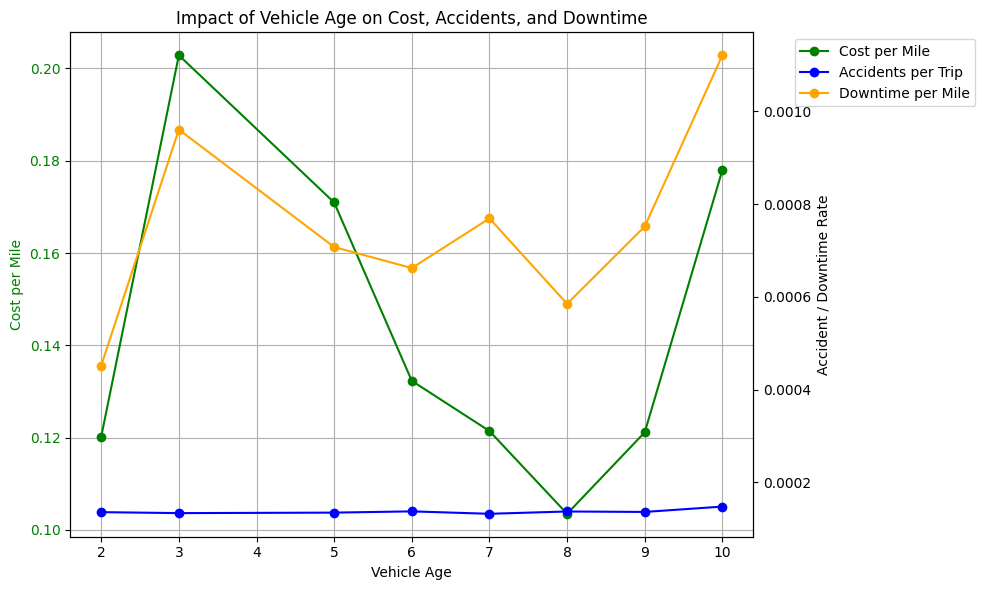

,vehicle_age,accident_count,total_trips,total_miles,total_downtime_hours,total_cost,accident_per_trip,downtime_per_mile,cost_per_mile
0,2,3,2111,22138.73,10.0,2661,0.000136,0.000452,0.120197
1,3,3,2141,22483.05,21.6,4561,0.000133,0.000961,0.202864
2,5,5,3479,37178.60,26.3,6356,0.000134,0.000707,0.170959
3,6,4,2764,29152.64,19.3,3857,0.000137,0.000662,0.132304
4,7,7,5010,53044.46,40.8,6441,0.000132,0.000769,0.121426
5,8,7,4885,51116.31,29.9,5290,0.000137,0.000585,0.103489
6,9,14,9800,102962.43,77.4,12474,0.000136,0.000752,0.121151
7,10,2,1353,13558.00,15.2,2413,0.000148,0.001121,0.177976


In [114]:


fig, ax1 = plt.subplots(figsize=(10,6))

# Left y-axis: Cost per Mile
ax1.plot(age_summary['vehicle_age'], age_summary['cost_per_mile'], marker='o', color='green', label='Cost per Mile')
ax1.set_xlabel('Vehicle Age')
ax1.set_ylabel('Cost per Mile', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.grid(True)

# Right y-axis for accident and downtime rates
ax2 = ax1.twinx()
ax2.plot(age_summary['vehicle_age'], age_summary['accident_per_trip'], marker='o', color='blue', label='Accidents per Trip')
ax2.plot(age_summary['vehicle_age'], age_summary['downtime_per_mile'], marker='o', color='orange', label='Downtime per Mile')
ax2.set_ylabel('Accident / Downtime Rate')
ax2.tick_params(axis='y')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.title('Impact of Vehicle Age on Cost, Accidents, and Downtime')
fig.tight_layout()
plt.show()

age_summary.head(10)



### Impact of Vehicle Age on Cost, Accidents, and Downtime

This graph visualizes how vehicle age affects three key metrics: cost per mile, accident rate per trip, and downtime per mile, based on a 6-month period of 50 fleet vehicles.

Cost per Mile: Costs are highest at vehicle age 3 (£0.20) before rising slightly at age 10. This pattern suggests that mid-aged vehicles may be more cost-efficient, while newer vehicles could incur higher costs due to early repairs or expensive parts scuh as  EV components, and older ones due to aging systems.

Accidents per Trip: Accident rates are low across all ages (~0.00013–0.00015), with minimal variation. This implies consistent driving behavior and possibly good safety standards fleet-wide. Given the rarity of accidents in the data, these rates are statistically stable but could mask small age-related effects.

Downtime per Mile: Downtime generally increases with vehicle age, as expected. It rises from 0.00045 (age 2) to a peak of 0.00112 (age 10), reflecting longer repairs and more frequent maintenance needs in older vehicles. Some mid-age dips in downtime may reflect greater vehicle reliability during the middle of the lifecycle, when components have stabilized but long-term wear hasn’t yet set in.

Overall, the trends align with real-world expectations: older vehicles tend to have higher downtime, and cost efficiency peaks in the mid-life of the fleet. While accident rates appear flat, this may reflect strong driver performance or limited event data. These findings support ongoing fleet aging analysis and suggest age-aware maintenance planning could reduce total operating cost.


In [118]:

vehicle_type_result= pd.merge(result,vehicle_data_df,on='vehicle_id',how='left')

vehicle_result.columns

Index(['event_id', 'vehicle_id', 'event_date', 'service_type', 'cost',
       'downtime_hours', 'claim_type', 'severity', 'vehicle_age',
       'assignment_id', 'contract_start', 'contract_end', 'driver_id', 'name',
       'age', 'licence_year', 'ratings', 'trip_count', 'total_mileage',
       'contract_days', 'experience', 'accident_count', 'make', 'model',
       'year', 'type', 'mileage_start', 'reg_plate', 'value'],
      dtype='object')

## 4. **Fuel Type & Operating Risk**  
   - Question: Do petrol, diesel, hybrid, or electric vehicles differ in accident rate or cost when adjusted for usage?  
   - Data: `vehicle_data_df` (type), merged accident and trip data

In [ ]:

vehicle_summary = (
    vehicle_type_result
    .groupby(['vehicle_id', 'type'])
    .agg({
        'event_id':     'nunique',             # total accidents
        'trip_count':   'first',               # trips already computed per driver
        'total_mileage':'first',               # mileage per driver
        'cost':    'sum'                       # cost
    }).rename(columns={
        'event_id':      'accident_count',
        'trip_count':    'total_trips',
        'total_mileage': 'total_miles', 
        'cost': 'total_cost'
    })
    .reset_index()
)


In [ ]:

vehicle_type_summary = (
    vehicle_type_result
    .groupby(['type'])
    .agg({
        'event_id':     'nunique',             # total accidents
        'trip_count':   'sum',               # trips already computed per driver
        'total_mileage':'sum',               # mileage per driver
        'cost':    'sum'                  # total donwtime hours 
    })
    .reset_index()
)

vehicle_type_summary['accident_per_trip']= vehicle_type_summary['event_id']/vehicle_type_summary['trip_count']
vehicle_type_summary['accident_per_mile']= vehicle_type_summary['event_id']/vehicle_type_summary['total_mileage']
vehicle_type_summary['cost_per_mile']= vehicle_type_summary['cost']/vehicle_type_summary['total_mileage']



vehicle_type_summary.head(5)


,type,event_id,trip_count,total_mileage,cost,accident_per_trip,accident_per_mile,cost_per_mile
0,Diesel,1,731,7848.69,643,0.001368,0.000127,0.081924
1,Electric,9,6253,66288.93,12518,0.001439,0.000136,0.188840
2,Hybrid,32,22422,235301.00,29040,0.001427,0.000136,0.123416
3,Petrol,3,2137,22195.60,1852,0.001404,0.000135,0.083440


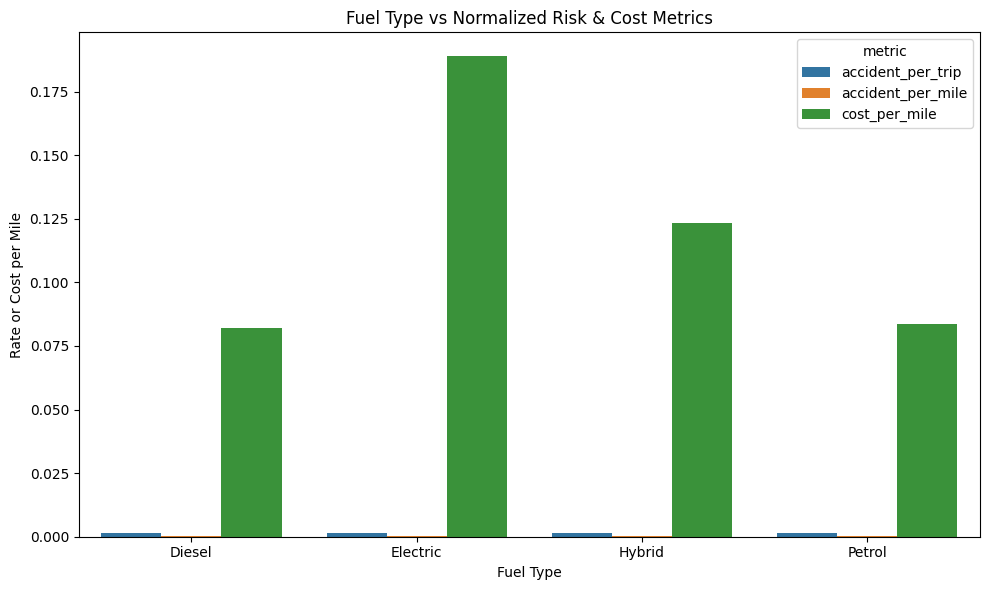

,type,event_id,trip_count,total_mileage,cost,accident_per_trip,accident_per_mile,cost_per_mile
0,Diesel,1,731,7848.69,643,0.001368,0.000127,0.081924
1,Electric,9,6253,66288.93,12518,0.001439,0.000136,0.188840
2,Hybrid,32,22422,235301.00,29040,0.001427,0.000136,0.123416
3,Petrol,3,2137,22195.60,1852,0.001404,0.000135,0.083440


In [129]:
melted = vehicle_type_summary.melt(id_vars='type', 
    value_vars=['accident_per_trip', 'accident_per_mile', 'cost_per_mile'], 
    var_name='metric', value_name='value'
)

plt.figure(figsize=(10,6))
sns.barplot(data=melted, x='type', y='value', hue='metric')
plt.title("Fuel Type vs Normalized Risk & Cost Metrics")
plt.ylabel("Rate or Cost per Mile")
plt.xlabel("Fuel Type")
plt.tight_layout()
plt.show()
vehicle_type_summary.head(5)

Despite differences in operating costs, the safety performance measured by accident frequency shows no significant variation by fuel type

In [132]:
result.columns
vehicle_profit_result= pd.merge(result,profit_vehicles_df,on='vehicle_id',how='left')

vehicle_profit_result.columns

Index(['event_id', 'vehicle_id', 'event_date', 'service_type', 'cost',
       'downtime_hours', 'claim_type', 'severity', 'vehicle_age',
       'assignment_id', 'contract_start', 'contract_end', 'driver_id', 'name',
       'age', 'licence_year', 'ratings', 'trip_count', 'total_mileage',
       'contract_days', 'experience', 'accident_count', 'Month',
       'Vehicle_Income', 'Maintenance_Cost', 'Profit_per_Vehicle'],
      dtype='object')

In [ ]:
trip_logs_df['start_ts']= pd.to_datetime(trip_logs_df['start_ts'],errors='coerce')

monthly_mileage = (
    trip_logs_df
    .assign(Month=trip_logs_df['start_ts'].dt.to_period('M'))
    .groupby('Month')['distance_miles']
    .sum()
    .reset_index()
    .rename(columns={'distance_miles': 'monthly_mileage'})
)


monthly_mileage.head()



,Month,monthly_mileage
0,2025-01,62694.47
1,2025-02,56580.67
2,2025-03,61119.57
3,2025-04,60753.33
4,2025-05,60925.57


5. **Time-Series Drivers of Cost & Profitability**
- Question: Are there seasonal or monthly patterns in accident frequency or maintenance cost that explain fluctuations in fleet profitability?


In [146]:
vehicle_profit_result.columns
vehicle_profit_result['Month'] = pd.to_datetime(vehicle_profit_result['event_date']).dt.to_period('M')

In [149]:



vehicle_profit_summary = (
    vehicle_profit_result
    .groupby('Month')
    .agg({
        'event_id': 'nunique',          # number of incidents (accidents + maintenance)
        'accident_count': 'sum',        # number of accidents
        'Maintenance_Cost': 'sum'      # total cost
    })
).reset_index()


vehicle_profit_summary['Month'] = vehicle_profit_summary['Month'].astype(str)
monthly_mileage['Month'] = monthly_mileage['Month'].astype(str)
merge_results= pd.merge(vehicle_profit_summary,monthly_mileage,on='Month',how='left')

# Normalize
merge_results['accidents_per_mile'] = ( merge_results['accident_count'] / merge_results['monthly_mileage'])

merge_results['cost_per_mile'] = (merge_results['Maintenance_Cost'] / merge_results['monthly_mileage'])


merge_results.head(7)

,Month,event_id,accident_count,Maintenance_Cost,monthly_mileage,accidents_per_mile,cost_per_mile
0,2025-01,14,244,15278.0,62694.47,0.003892,0.243690
1,2025-02,9,174,8888.0,56580.67,0.003075,0.157085
2,2025-03,6,84,4536.0,61119.57,0.001374,0.074215
3,2025-04,4,36,3085.0,60753.33,0.000593,0.050779
4,2025-05,6,60,4620.0,60925.57,0.000985,0.075830
5,2025-06,6,36,1881.0,61204.33,0.000588,0.030733


In [152]:
financial_data_df.head()

,Month,Total_Revenue,Total_Maintenance,Employee_Salary,Expenses,Profit_Before_Tax,Tax,Profit_After_Tax
0,2025-01,66011.0,6532.0,9416.67,28971.92,21090.41,4007.1779,17083.23
1,2025-02,41644.0,6389.0,9416.67,28971.92,-3133.59,-595.3821,-2538.21
2,2025-03,49522.0,7443.0,9416.67,28971.92,3690.41,701.1779,2989.23
3,2025-04,44064.0,5387.0,9416.67,28971.92,288.41,54.7979,233.61
4,2025-05,46609.0,9302.0,9416.67,28971.92,-1081.59,-205.5021,-876.09


## 5.1 **Time-Series Drivers of Profitability**

- Question: How do these monthly cost drivers relate to profitability (e.g., profit after tax)?
- Data: Merge cost/time-series data with financials (profit_vehicles_df), then analyze or visualize how cost per mile trends correspond to fluctuations in profit.


In [ ]:
financial_data_df['Month'] = financial_data_df['Month'].astype(str)
merge_results['Month'] = merge_results['Month'].astype(str)

# Merge on Month
combined_df = pd.merge(financial_data_df, merge_results, on='Month', how='inner')

# Check the combined table
print(combined_df[['Month', 'cost_per_mile', 'Profit_After_Tax']])

     Month  cost_per_mile  Profit_After_Tax
0  2025-01       0.243690          17083.23
1  2025-02       0.157085          -2538.21
2  2025-03       0.074215           2989.23
3  2025-04       0.050779            233.61
4  2025-05       0.075830           -876.09
5  2025-06       0.030733          -8144.22


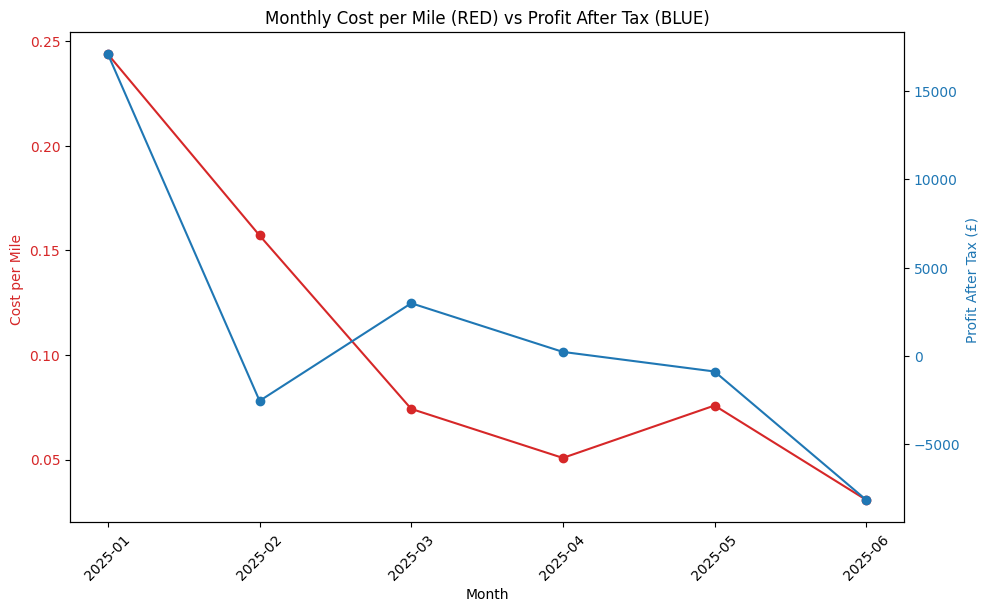

In [156]:
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.set_xlabel('Month')
ax1.set_ylabel('Cost per Mile ', color='tab:red')
ax1.plot(combined_df['Month'], combined_df['cost_per_mile'], color='tab:red', marker='o', label='Cost per Mile')
ax1.tick_params(axis='y', labelcolor='tab:red')
plt.xticks(rotation=45)

ax2 = ax1.twinx()
ax2.set_ylabel('Profit After Tax (£) ', color='tab:blue')
ax2.plot(combined_df['Month'], combined_df['Profit_After_Tax'], color='tab:blue', marker='o', label='Profit After Tax')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.title('Monthly Cost per Mile (RED) vs Profit After Tax (BLUE)')
plt.show()

The graph reveals a strong negative correlation between cost per mile and profit after tax over the past six months. Months with higher cost per mile tend to show reduced profitability or even losses, indicating that operational costs related to maintenance and accidents significantly impact the fleet’s financial performance.